# PySIAF Observation Footprint Viewer
***

## Learning Goals
- Know the requirements for generating a telescope footprint
- Create a plot of a footprint in the telescope's reference frame
- Create a plot of a footprint on the sky

## Introduction
This Notebook is a replacement for a web-based footprint viewer, and is designed as a "quick look" tool. Scientists intending to propose for Observations should use the [Astronomer's Proposal Tool (APT)](https://www.stsci.edu/scientific-community/software/astronomers-proposal-tool-apt).

Note that since [PySIAF](https://pysiaf.readthedocs.io/en/latest/) only works for HST, JWST, and Roman, you cannot generate footprints for other telescopes using this notebook.
## Imports
- `ipyaladin` plots the footprints on to a survey background
- `numpy` is not listed in the import cell, but is necessary to run the `selectSIAF` script
- `selectSIAF` is a script that uses `SIAF` to generate the telescope aperture names. Curious readers may wish to explore this file.
-  `SIAF` will translate the telescope pointing into corresponding sky footprints
-  `time` adds a pause to give Aladin time to load

In [1]:
from astropy.coordinates import SkyCoord
from ipyaladin import Aladin
from regions import Regions
from selectSIAF import defineApertures, getVertices, computeStcsFootprint, computeRegionFootprint
from getCatalog import gsss_stcsSearchUrl

import matplotlib.pyplot as plt
import os
import pysiaf
import time

## Select a Telescope, Instrument, and Aperture
In order to display a fooprint, we must first select three criteria:
1. Telescope. This must be a telescope with data in [pysiaf](https://pysiaf.readthedocs.io/en/stable/index.html); at present, this is HST, JWST, and Roman.
2. Instrument. The instrument used for the observation. The valid acronyms are listed in code comments in the cell below.
3. Aperture. For a full list of valid apertures, see the instrument documentation:
    - [HST User Documentation Homepage](https://hst-docs.stsci.edu)
    - [JWST MIRI Homepage](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument) (JWST has no instrument homepage; use the site navigation to reach other instrument pages)
    - [Roman Instruments Homepage](https://roman-docs.stsci.edu/roman-instruments-home)

### Example: Roman WFI
In the code cell below, we'll set some variables to hold these three selections. In this example, we're going to plot all 18 apertures from the Roman Space Telescope's Wide Field Instrument.

For completeness, examples for HST and JWST are available but commented out.

In [2]:
# define telescope, instrument, and aperture

selectedTelescope = 'roman'
selectedInstrument = 'WFI'      # Allowed options ALL, WFI, CGI
selectedAperture = 'ALL'        # Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'hst'
# selectedInstrument = 'ALL'     # Allowed options ALL, ACS, COS, FGS, NICMOS, STIS, WFC3
# selectedAperture = 'ALL'       # Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'jwst'
# selectedInstrument = 'ALL'     # Allowed options ALL, FGS, MIRI, NIRCAM, NIRSPEC, NIRISS
# selectedAperture = 'ALL'       # Allowed options ALL or individual apertures listed in instrument documentation

## Configure Apertures, Telescope Coordinate System

To simplify this Notebook, the `defineApertures` function from `selectSIAF` is essentially a lookup table, translating user-friendly instrument names into the correct corresponding apertures. 

This same function also generates the correct `V2Ref` and `V3Ref` offset angles. These V2/V3 values answer the question "what angles are there between this instrument and the line-of-sight of the telescope?". This is quite useful since, barring a catastrophic event, the instruments do not change their alignment relative to the line-of-sight.


In [3]:
# Set up aperture list and reference coordinates
apertureList, V2Ref, V3Ref = defineApertures(selectedTelescope, selectedInstrument, selectedAperture)

### Optional: Plot Footprint in Telescope Frame

Although not necessary to generate the final image, it is possible to plot the telescope apertures. We'll be plotting in a coordinate system that uses the telescope's pointing direction as (0,0); because of this, we don't need information about the celestial target or roll angle.

*Note: labels are useful for Roman WFI, but may be cluttered for other missions. You can toggle them off by setting `label=False` below.*

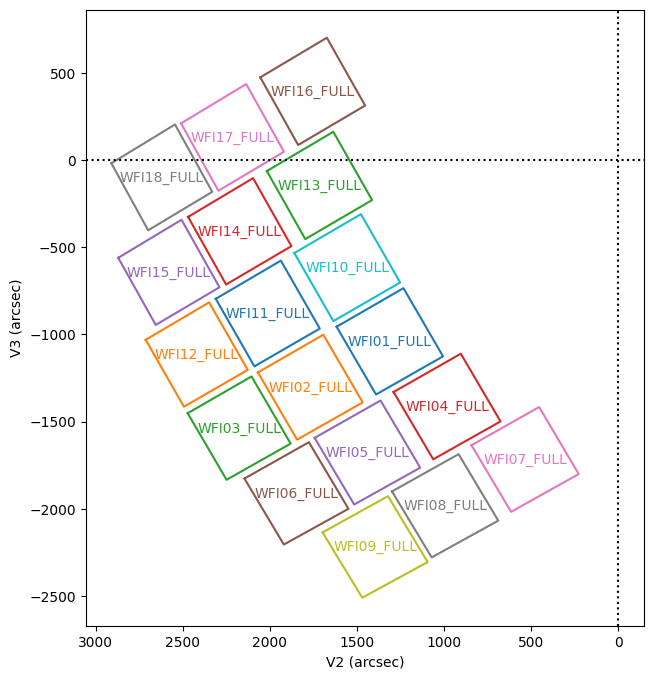

In [4]:
# OPTIONAL : set up plot of apertures (only works for QUAD, RECT, PICK aperture shapes)

# Set up the figure
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
plt.gca().invert_xaxis()

# iterate through apertures, then plot
for aperture in apertureList:
    # circles are not properly plotted, skip
    if aperture.AperShape != 'CIRC':
        # set labels=False to remove them
        aperture.plot(label=True)

# Add guide lines for boresight (V2, V3) = (0, 0)
plt.axvline(color='k', linestyle=":")
plt.axhline(color='k', linestyle=":")

# Display the plot
plt.show() 

## Specifying a Target

For convenience, we can use the `resolve_object` function from the MAST module of `astroquery` to get our coordinates. This isn't necessary if you already know the exact coordinates; however, you should note that the additional formatting steps below are necessary for `PySIAF` and `Aladin` to understand your query.

In [5]:
# Resolve the target name to coordinates
#coords = Mast.resolve_object("M101")
#coords

# Specify RA, Dec coordinates (This happens to be Arp 244)
coords = SkyCoord(180.46, -18.89, frame='icrs', unit='deg')

Using MAST to resolve our target returns a [skycoord](https://docs.astropy.org/en/stable/coordinates/) object. We need two different formats to satisfy `pysiaf` and `Aladin`. `pysiaf` requires separate ra/dec objects, while `Aladin` is looking for a string containing both.

Fortunately, `skycoord` objects are flexible enough to handle both of these requirements with straightforward calls:

In [6]:
# get the values for SIAF
targetRa = coords.ra
targetDec = coords.dec

coords_str = coords.to_string()

# print out these values to check their conversions
print(f"RA:     {targetRa}\nDEC:    {targetDec}\nString: {coords_str}")

RA:     180.46 deg
DEC:    -18.89 deg
String: 180.46 -18.89


There's rounding in our RA/Dec as a result of our `to_string()` call. As we'll see later on, we only need this string to point the Aladin viewer at the right section of the sky; a little bit of rounding won't affect our view much.

## Telescope Position Angle

The last variable we need to set before using `pysiaf` is the telescope position angle. From the docstring of the `attitude_matrix` function:
>Position angle of V3 axis at nu2,nu3 measured from North to East (default unit is degree)

In plain English, this is the telescope roll angle; with the telescope fixed on the target, it rotates around its V1 (line-of-sight) axis. Modifying this value will cause the footprints to "roll" around the target.

In [7]:
# can be any value between 0 and 360
telescopePositionAngle = 0

## Generate The Attitude Matrix

At this point, we've generated footprints in the telescope's field of view. Now, we need to translate this into a view on the sky, in RA/Dec coordinates. This is handled by the `attitude_matrix` function, which is doing some matrix multiplication behind the scenes.

In [8]:
# Set telescope pointing matrix: "attitude matrix"
attmat = pysiaf.utils.rotations.attitude_matrix(V2Ref, V3Ref, targetRa, targetDec, telescopePositionAngle)

## Calculate Sky Regions

The final step is to convert to the [IVOA Space-Time Coordinate Metadata Linear String Implementation (STS-C)](https://ivoa.net/documents/STC-S/). Do not fear this verbose name; it's a method of standardizing footprints in string formats. The specifics depend on the particular shape used. For the curious, the `computeStcsFootprint` function from `selectSIAF` is what calcuates these strings in this Notebook.

Since `Aladin` knows how to parse this format, it will be able to plot it on a sky background of our choice. It is not particularly human readable, but we'll print it out anyway.

In [9]:
# Loop through aperture list  (only works for QUAD, RECT, CIRC aperture shapes)
# Transform to sky coordinates, build footprints for passing to Aladin
combinedSregion = ''
for apertureSiaf in apertureList:
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    
    # Skip PICK which do not have vertices (HST/FGS is only instrument affected)
    if (xVertices is not None and yVertices is not None):
        skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
        apertureSregion = computeStcsFootprint(apertureSiaf, skyRa, skyDec)
        combinedSregion += apertureSregion
        
print('\n'+combinedSregion)


POLYGON ICRS 180.48076550 -18.90746286 180.36817811 -18.84599471 180.30142864 -18.95458865 180.41432099 -19.01546832 POLYGON ICRS 180.61337499 -18.98023404 180.50312512 -18.92019002 180.43676136 -19.02805554 180.54742848 -19.08735321 POLYGON ICRS 180.73180882 -19.04512674 180.62417451 -18.98663388 180.55826413 -19.09366679 180.66641297 -19.15127114 POLYGON ICRS 180.38476223 -19.01148376 180.27151502 -18.95039598 180.20444240 -19.05820395 180.31779889 -19.11865545 POLYGON ICRS 180.51784519 -19.08456614 180.40670457 -19.02503169 180.33977788 -19.13204690 180.45115278 -19.19078688 POLYGON ICRS 180.63621633 -19.14933193 180.52749585 -19.09145779 180.46082317 -19.19758215 180.56989072 -19.25453642 POLYGON ICRS 180.25335389 -19.09618812 180.13933659 -19.03514272 180.07241672 -19.14183101 180.18632000 -19.20224512 POLYGON ICRS 180.38735634 -19.16989687 180.27504199 -19.11044795 180.20799062 -19.21633154 180.32031836 -19.27498977 POLYGON ICRS 180.50441635 -19.23522897 180.39414431 -19.1774722

### Optional: Create DS9 region file with footprints

Although not necessary to generate the final image, it is possible to write the footprints to a DS9 region file. Here, we'll create a file called `regionTest.reg`.

In [10]:
# OPTIONAL build same footprints for creating a DS9 region file

regionList = []
for i in range(len(apertureList)):
    apertureSiaf = apertureList[i]
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    
    # Skip PICK which do not have vertices
    if (xVertices is not None and yVertices is not None):
        skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
        apertureRegion = computeRegionFootprint(apertureSiaf, skyRa, skyDec)
        regionList.append(apertureRegion)
        
# Provide a writeable file location on your system
regionFile = 'regionTest.reg'
if os.path.isfile(regionFile):
    os.remove(regionFile)
combinedRegion = Regions(regionList)
combinedRegion.write(regionFile)

## Initialize Aladin
Let's start the Aladin viewer. We're loading a default field of view of 1 degree, with DSS as the background survey. Depending on your screen size, you may need to adjust the `height` (in pixels) to get the best view.

**NOTE:** The footprint will not be displayed in the rendered HTML. Please download and run it locally, or use [TIKE](https://timeseries.science.stsci.edu).

In [11]:
aladin = Aladin(height=600, fov=1, survey="P/DSS2/color", target=coords_str)
aladin

Aladin(survey='P/DSS2/color')

In [12]:
# Pause for 2 seconds to give Aladin time to load the viewer
# Necessary when using "Run All Cells", or even just hitting 'shift+enter' fast enough
time.sleep(2)

# Add the footprint with a hexcode for the color; you can also enter, e.g. "green"
aladin.add_overlay_from_stcs(combinedSregion, color="#70CBFF")

Done! The roman footprints are now visible in the Aladin window.

Done! The footprint is now visible in the Aladin window.

## Add a Catalog

You can also overlay catalog sources onto the viewer. Clicking on these sources will show their names, RA/decs, and any other information included in the catalog.

In [13]:
# Optional Retrieve catalog sources from MAST that are within footprint and overlay them
# Supported catalogs : 'GSC11', 'GSC243', 'GSC30', '2MASS', 'GAIADR3'  

#selectedCatalog = 'GSC11'
#selectedCatalog = 'GSC243'
#selectedCatalog = 'GSC30'
#selectedCatalog = '2MASS'
selectedCatalog = 'GAIADR3'

url = gsss_stcsSearchUrl(combinedSregion,  catalog=selectedCatalog)
options = {'source_size': 12, 'onClick': 'showTable', 'name': selectedCatalog}
aladin.add_catalog_from_URL(url, options)

## Citations
If you use ipyaladin for your work or research, you should cite it with the following acknowledgment:

This research made use of ipyaladin, developed by CDS, Strasbourg Astronomical Observatory, France (DOI: [10.26093/kpaw-kb74](https://doi.org/10.26093/kpaw-kb74)).

[2020ASPC..522..117B](https://ui.adsabs.harvard.edu/abs/2020ASPC..522..117B) - ipyaladin: Enabling Aladin Lite in Jupyter Notebooks (Boch T. et al.)


## About this Notebook
If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu.


**Authors:** Brian McLean, Thomas Dutkiewicz <br>
**Keywords:** Footprints <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 